[Keras Tutorial](https://keras.io/guides/transfer_learning/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, utils, applications, regularizers, optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.backend import clear_session
from sklearn.metrics import classification_report
from PIL import Image
import time

In [2]:
def history_plot(history):
    fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 5))

    axs[0].plot(history.history['loss'], label='loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()
    axs[1].plot(history.history['accuracy'], label='accuracy')
    axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend()
    plt.show()

In [3]:
num_classes = 10
img_width = img_height = 56
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

In [4]:
# x_train = utils.normalize(x_train, axis=1)
# x_test = utils.normalize(x_test, axis=1)

x_train = x_train.reshape(-1, 28, 28, 1)
x_test= x_test.reshape(-1, 28, 28, 1)

print(x_train.shape)
print(x_test.shape)

x_train = np.concatenate([x_train] * 3, axis=3)
x_test = np.concatenate([x_test] * 3, axis=3)


print(x_train.shape)
print(x_test.shape)

x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((img_width,img_height), resample=Image.BICUBIC)) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((img_width,img_height), resample=Image.BICUBIC)) for im in x_test])

x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.shape)
print(x_test.shape)

# x_train = applications.vgg16.preprocess_input(x_train)
# x_test = applications.vgg16.preprocess_input(x_test)

# print(x_train.shape)
# print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 28, 28, 3)
(10000, 28, 28, 3)
(60000, 56, 56, 3)
(10000, 56, 56, 3)


In [5]:
with open(f'train{img_width}.npy', 'wb') as f:
    np.save(f, x_train)

with open(f'test{img_width}.npy', 'wb') as f:
    np.save(f, x_test)

In [4]:
with open(f'train{img_width}.npy', 'rb') as f:
	x_train = np.load(f)

with open(f'test{img_width}.npy', 'rb') as f:
	x_test = np.load(f)

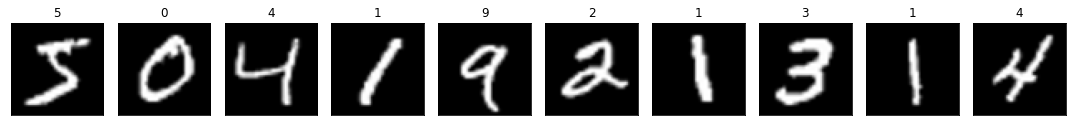

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
	ax.imshow(x_train[i])
	ax.set_title(chr(y_train[i] + 48))
plt.tight_layout()
plt.show()

In [5]:
#base_model = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3), alpha=0.35)
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
#base_model = applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.summary()


for layer in base_model.layers[:-3]:
    layer.trainable = False

x = base_model.output

x = Flatten()(x)
x = BatchNormalization()(x)
#x = Dense(128, kernel_regularizer=regularizers.l1(0.001), activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
#x = Dense(64, kernel_regularizer=regularizers.l2(0.001), activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
# x = Dropout(0.7)(x)
#x = Dense(32, activation = 'relu')(x)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = output)

# Компиляция модели
model.compile(optimizer = optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [6]:
start = time.time() 
history = model.fit(x_train, y_train_cat, validation_split=0.2, epochs=20, batch_size=512)
print('Время вычислений:', time.time() - start)
clear_session()

Epoch 1/20
94/94 [==============================] - 29s 208ms/step - loss: 0.2300 - accuracy: 0.9318 - val_loss: 0.1581 - val_accuracy: 0.9487
Epoch 2/20
94/94 [==============================] - 13s 143ms/step - loss: 0.0551 - accuracy: 0.9835 - val_loss: 0.0731 - val_accuracy: 0.9789
Epoch 3/20
94/94 [==============================] - 14s 146ms/step - loss: 0.0413 - accuracy: 0.9876 - val_loss: 0.1135 - val_accuracy: 0.9663
Epoch 4/20
94/94 [==============================] - 13s 141ms/step - loss: 0.0356 - accuracy: 0.9891 - val_loss: 0.0649 - val_accuracy: 0.9813
Epoch 5/20
94/94 [==============================] - 13s 142ms/step - loss: 0.0282 - accuracy: 0.9916 - val_loss: 0.0954 - val_accuracy: 0.9711
Epoch 6/20
94/94 [==============================] - 13s 141ms/step - loss: 0.0260 - accuracy: 0.9920 - val_loss: 0.0687 - val_accuracy: 0.9797
Epoch 7/20
94/94 [==============================] - 13s 142ms/step - loss: 0.0243 - accuracy: 0.9931 - val_loss: 0.0561 - val_accuracy: 0.9848

In [7]:
val_loss, val_acc = model.evaluate(x_test, y_test_cat)
print('Val(test set) accuracy: ', val_acc)
print('Accuracy: ', history.history['accuracy'][-1])
print('Val accuracy: ', history.history['val_accuracy'][-1])


313/313 [==============================] - 5s 14ms/step - loss: 0.0556 - accuracy: 0.9874
Val(test set) accuracy:  0.9873999953269958
Accuracy:  0.9976666569709778
Val accuracy:  0.9865833520889282


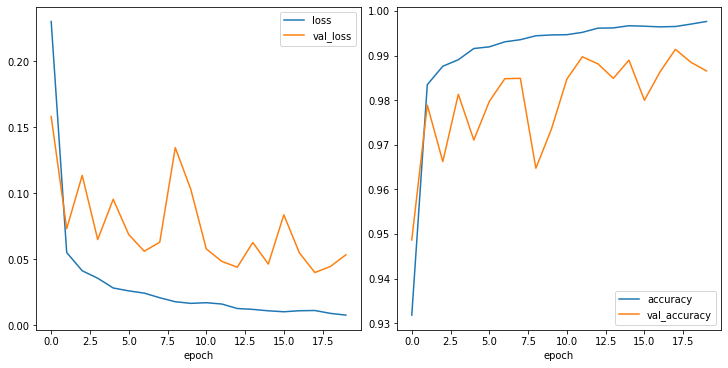

In [8]:
history_plot(history)

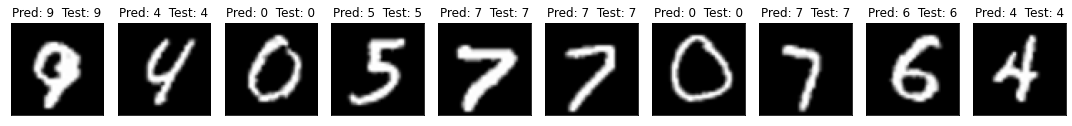

In [9]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

rs = np.random.randint(0, len(predictions), 10)

# Вывод 10 результатов
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    idx = rs[i]
    ax.imshow(x_test[idx], cmap=plt.cm.binary)
    ax.set_title('Pred: ' + chr(predictions[idx] + 48) + '  Test: ' + chr(y_test[idx] + 48))
plt.tight_layout()
plt.show()

In [12]:
model.save('vgg16_56_mnist_99p')

INFO:tensorflow:Assets written to: vgg16_56_mnist_99p\assets


In [10]:
mask = predictions == y_test
x_false = x_test[~mask]
print(x_false.shape)

(126, 56, 56, 3)


In [13]:
print(classification_report(y_test, predictions, digits=8))

              precision    recall  f1-score   support

           0  1.00000000 0.98877551 0.99435608       980
           1  0.98353553 1.00000000 0.99169943      1135
           2  0.99219512 0.98546512 0.98881867      1032
           3  0.94924812 1.00000000 0.97396336      1010
           4  0.99896266 0.98065173 0.98972251       982
           5  0.99654378 0.96973094 0.98295455       892
           6  0.99372385 0.99164927 0.99268548       958
           7  0.99503476 0.97470817 0.98476658      1028
           8  0.98769231 0.98870637 0.98819908       974
           9  0.98231827 0.99108028 0.98667982      1009

    accuracy                      0.98740000     10000
   macro avg  0.98792544 0.98707674 0.98738455     10000
weighted avg  0.98769518 0.98740000 0.98743132     10000

